# A visual exploration of KL-divergence

In [1]:
import numpy as np
import matplotlib.pyplot as plt

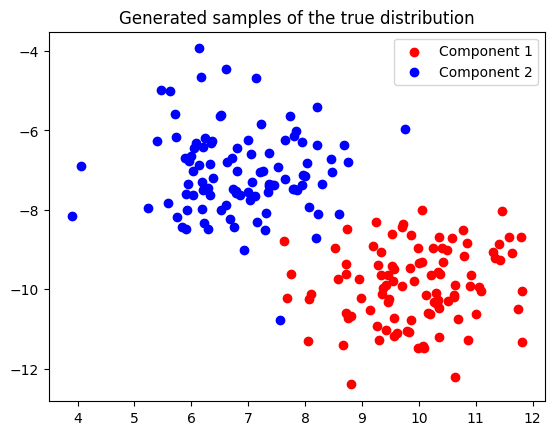

In [2]:
rng = np.random.default_rng(seed = 0)

N = 100
D = 2

# distrubution 1 (True Distribution)
p1 = rng.normal(loc=np.array([10, -10]), scale=1, size=(N, D))
p2 = rng.normal(loc= np.array([7, -7]), scale=1, size=(N, D))
params_P = np.vstack([np.array([10, -10, 1]),
                     np.array([7, -7, 1])])  # Fixed: was [7, -1, 1]

P = np.vstack([p1, p2])

# plot distrubution
plt.scatter(p1[:, 0], p1[:, 1], color="r", label="Component 1")
plt.scatter(p2[:, 0], p2[:, 1], color="b", label="Component 2")
plt.title("Generated samples of the true distribution")
plt.legend()

# General objective of the problem

Find $Q_{mean}$, $Q_{var}$ such that $D_{KL}(P||Q)$ OR $D_{KL}(Q||P)$ is minimzed

In [3]:
from scipy.stats import norm
from scipy.special import logsumexp

In [4]:
def forwardKL_obj(Q_params, input_params) -> float:
    """
    Computes the Monte-Carlo Estimate of forward KL between P & Q: KL(P||Q)
    
    For minimizing KL(P||Q) w.r.t Q, we only need to maximize E_P[log Q(x)]
    since E_P[log P(x)] is constant.
    """
    Q_mean, Q_var = Q_params[:2], Q_params[-1]
    P_params, N_samples, seed = input_params
    M = P_params.shape[0]
    
    # Use fixed seed for consistent gradient estimates
    rng_local = np.random.default_rng(seed=seed)

    # Sample from the mixture P
    component_N = rng_local.choice(M, N_samples)
    P_samples_ND = rng_local.normal(loc=P_params[component_N, :2], 
                                     scale=P_params[component_N, -1][:, np.newaxis], 
                                     size=(N_samples, 2))
    
    # log Q(x) - single Gaussian
    logQ_ND = norm.logpdf(P_samples_ND, loc=Q_mean, scale=Q_var)
    logQ_N = np.sum(logQ_ND, axis=1)

    # Minimize negative log-likelihood under Q (equivalent to minimizing KL)
    return -np.mean(logQ_N)

In [5]:
def reverseKL_obj(Q_params, input_params) -> float:
    """
    Computes the Monte Carlo Estimate for Reverse KL: KL(Q||P)
    """
    Q_mean, Q_var = Q_params[:2], Q_params[-1]
    P_params, N_samples, seed = input_params
    M = P_params.shape[0]
    
    rng_local = np.random.default_rng(seed=seed)

    # Sample from Q
    Q_samples_ND = rng_local.normal(loc=Q_mean, scale=Q_var, size=(N_samples, 2))
    
    # log Q(x)
    logQ_ND = norm.logpdf(Q_samples_ND, loc=Q_mean, scale=Q_var)
    logQ_N = np.sum(logQ_ND, axis=1)

    # log P(x) for mixture
    logP_NMD = norm.logpdf(Q_samples_ND[:, np.newaxis, :], 
                           loc=P_params[np.newaxis, :, :2], 
                           scale=P_params[np.newaxis, :, -1][:, :, np.newaxis])
    logP_NM = np.sum(logP_NMD, axis=2)
    logP_N = logsumexp(logP_NM, axis=1) - np.log(M)
    
    return np.mean(logQ_N - logP_N)

# Optimize Forward KL

In [6]:
from scipy.optimize import minimize

# Use data statistics for initialization
data_mean = P.mean(axis=0)
data_std = P.std()

# Use bounds to keep variance in reasonable range
bounds = [(None, None), (None, None), (0.5, 5.0)]

# Forward KL with fixed seed for consistent estimates
x_init = np.array([data_mean[0], data_mean[1], 2.0])

result = minimize(forwardKL_obj, x0=x_init, args=((params_P, 2000, 42),), 
                  bounds=bounds, method='L-BFGS-B')
Q_params_forward = result.x

print(f"Forward KL optimization (mean-seeking):")
print(f"  Q_mean: [{Q_params_forward[0]:.2f}, {Q_params_forward[1]:.2f}]")
print(f"  Q_std: {Q_params_forward[2]:.2f}")

Forward KL optimization (mean-seeking):
  Q_mean: [8.49, -8.52]
  Q_std: 1.80


(np.float64(0.8924668957343277),
 np.float64(13.362920783773124),
 np.float64(-14.359799406652852),
 np.float64(-3.437494873060544))

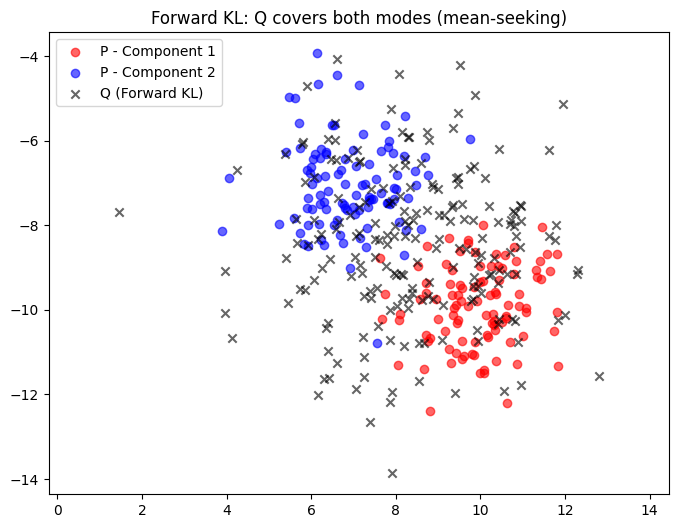

In [7]:
Q_forward = rng.normal(loc=Q_params_forward[:2], scale=Q_params_forward[-1], size=(200, 2))

# plot distribution
plt.figure(figsize=(8, 6))
plt.scatter(p1[:, 0], p1[:, 1], color="r", alpha=0.6, label="P - Component 1")
plt.scatter(p2[:, 0], p2[:, 1], color="b", alpha=0.6, label="P - Component 2")
plt.scatter(Q_forward[:, 0], Q_forward[:, 1], marker="x", color="black", alpha=0.6, label="Q (Forward KL)")
plt.title("Forward KL: Q covers both modes (mean-seeking)")
plt.legend()
plt.axis('equal')

In [8]:
# Reverse KL - mode seeking behavior
# Try initializing near each mode and pick best result
results_rev = []

for mode_idx in range(2):
    x_init_rev = np.array([params_P[mode_idx, 0], params_P[mode_idx, 1], 1.0])
    result_rev = minimize(reverseKL_obj, x0=x_init_rev, args=((params_P, 2000, 123),), 
                          bounds=bounds, method='L-BFGS-B')
    results_rev.append((result_rev.fun, result_rev.x))

# Take the one with lowest KL
best_idx = np.argmin([r[0] for r in results_rev])
Q_params_reverse = results_rev[best_idx][1]

print(f"Reverse KL optimization (mode-seeking):")
print(f"  Q_mean: [{Q_params_reverse[0]:.2f}, {Q_params_reverse[1]:.2f}]")
print(f"  Q_std: {Q_params_reverse[2]:.2f}")
print(f"  (Converged near mode {best_idx + 1})")

Reverse KL optimization (mode-seeking):
  Q_mean: [7.16, -7.17]
  Q_std: 1.11
  (Converged near mode 2)


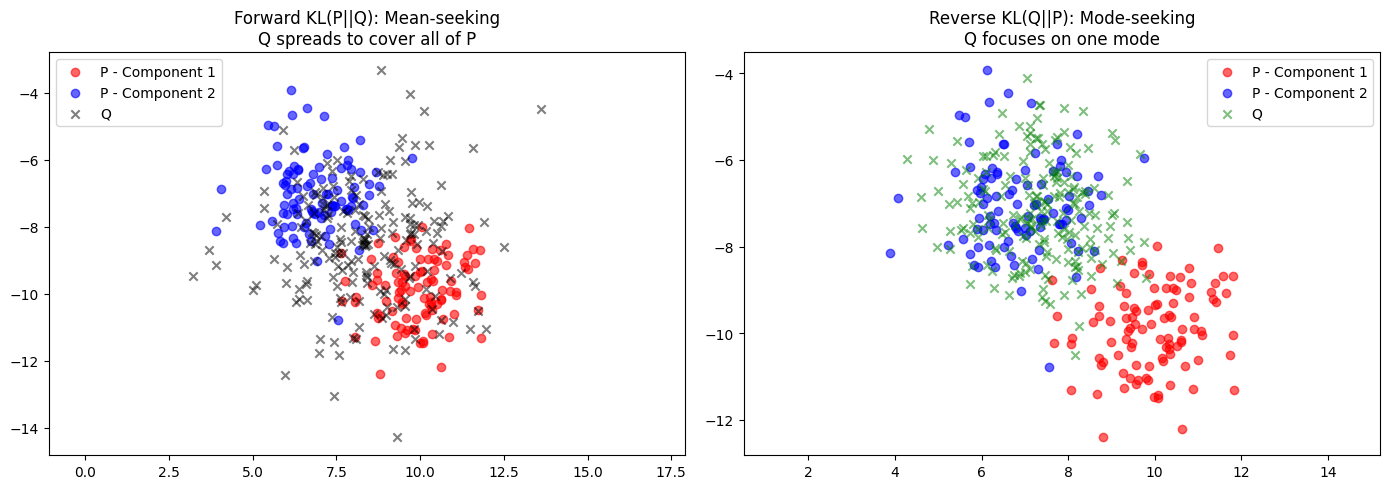

In [ ]:
# Compare Forward vs Reverse KL
Q_forward = rng.normal(loc=Q_params_forward[:2], scale=Q_params_forward[-1], size=(200, 2))
Q_reverse = rng.normal(loc=Q_params_reverse[:2], scale=Q_params_reverse[-1], size=(200, 2))

fig, axes = plt.subplots( 1, 2, figsize=(14, 5))

# Forward KL
axes[0].scatter(p1[:, 0], p1[:, 1], color="r", alpha=0.6, label="P - Component 1")
axes[0].scatter(p2[:, 0], p2[:, 1], color="b", alpha=0.6, label="P - Component 2")
axes[0].scatter(Q_forward[:, 0], Q_forward[:, 1], marker="x", color="black", alpha=0.5, label="Q")
axes[0].set_title("Forward KL(P||Q): Mean-seeking\nQ spreads to cover all of P")
axes[0].legend()
axes[0].axis('equal')

# Reverse KL
axes[1].scatter(p1[:, 0], p1[:, 1], color="r", alpha=0.6, label="P - Component 1")
axes[1].scatter(p2[:, 0], p2[:, 1], color="b", alpha=0.6, label="P - Component 2")
axes[1].scatter(Q_reverse[:, 0], Q_reverse[:, 1], marker="x", color="green", alpha=0.5, label="Q")
axes[1].set_title("Reverse KL(Q||P): Mode-seeking\nQ focuses on one mode")
axes[1].legend()
axes[1].axis('equal')

plt.tight_layout()